<a href="https://colab.research.google.com/github/Caio-Oliveira98/ML/blob/main/Projeto_Sprint_Sohipren_Pipeline_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto: Previsão de Vendas - Sohipren
## Grupo
Caio Santiago de Oliveira RM 559788
Fabrício França RM 559860
Felipe Sayeg RM 560366
Diogo Cedola RM 559797
Moacyr Cabral RM 559263
## 1. Entendimento do Problema

A Sohipren é uma empresa com foco em fornecimento de peças automotivas. Um dos seus grandes desafios é prever a demanda de vendas futuras de forma precisa para:

- Otimizar a gestão de estoque;
- Reduzir perdas com produtos parados;
- Aumentar a eficiência na entrega;
- Melhorar a experiência do cliente.

Este projeto visa construir uma solução preditiva utilizando técnicas de Machine Learning e Séries Temporais para antecipar vendas futuras — por produto e por região.


## 2. Coleta e Pré-visualização dos Dados

Utilizaremos um arquivo Excel com os dados históricos de vendas da Sohipren.


In [ ]:
# 📌 Este bloco realiza uma etapa importante da pipeline
# Explicação geral:
# - Aqui você verá desde pré-processamento, modelagem, até geração de gráficos.


import pandas as pd
import numpy as np
# Gera um gráfico com os dados agrupados
import matplotlib.pyplot as plt
import seaborn as sns
# Define e treina um modelo Random Forest para previsão
from sklearn.ensemble import RandomForestRegressor
# Define e treina um modelo SARIMAX para modelar os resíduos
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Leitura dos dados
# Carrega o arquivo Excel com os dados de vendas
df = pd.read_excel("FATURAMENTO_GERAL_DETALHADO000023 (1).xlsx", parse_dates=["EMISSÃO"])
df.columns = df.columns.str.strip().str.upper()
df.head()

,CÓD. EMPRESA,RAZÃO SOCIAL EMPRESA,NF/CT-E,CFOP,EMISSÃO,RAZÃO SOCIAL CLIENTE,UF,CÓD.MAT.,DESCRIÇÃO MATERIAL,UNID. MEDIDA,QUANTIDADE,VALOR TOTAL
0,1,SOHIPREN DO BRASIL COMERCIAL E INDUSTRIAL LTDA.,603.0,6101.0,2016-01-04,POCHINI FABRICACAO E VENDA DE EQUIPTOS INDUSTR...,MG,5.0220.L020110.0,"BOD 22,5 E.C.G3/16.G3.L",UN,1.0,632.0
1,1,SOHIPREN DO BRASIL COMERCIAL E INDUSTRIAL LTDA.,604.0,5101.0,2016-01-04,FABRICA DE MAQUINAS COPLING LTDA,SP,5.0505.0504066.0,MC1 50 201.1.21.86.63,UN,1.0,562.0
2,1,SOHIPREN DO BRASIL COMERCIAL E INDUSTRIAL LTDA.,605.0,5101.0,2016-01-05,CEC HIDRAULICA COMERCIO E REPRESENTACAO LTDA,SP,5.0201.0540607.0,"BOD 2,5 C11.C.C3.L",UN,1.0,237.0
3,1,SOHIPREN DO BRASIL COMERCIAL E INDUSTRIAL LTDA.,610.0,6101.0,2016-01-05,HIDROFORT TECNOMETAL DO BRASIL LTDA,RS,5.0205.L019630.0,BOI 8 B1.P1.C3.L,UN,2.0,570.0
4,1,SOHIPREN DO BRASIL COMERCIAL E INDUSTRIAL LTDA.,609.0,5101.0,2016-01-05,BRS AUTOMACAO INDUSTRIAL LTDA,SP,5.0205.L020070.0,BOD 8 C11.C.C3.T - 05 BAR,UN,1.0,329.0


## 3. Análise Exploratória de Dados (EDA)

Vamos analisar o comportamento das vendas por tempo, região e produto para entender padrões.


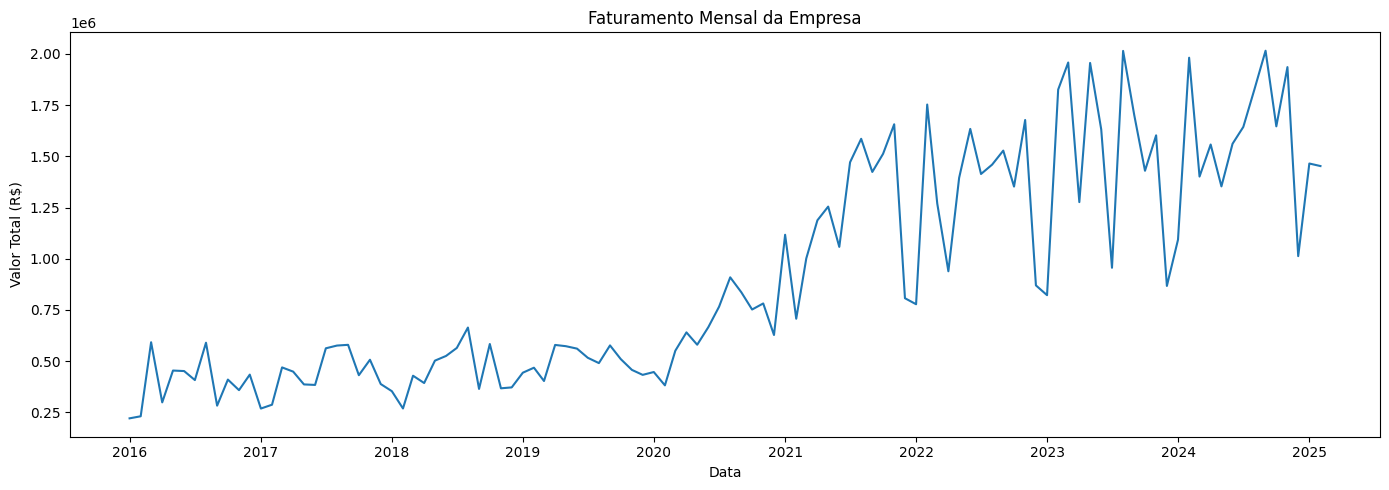

In [ ]:
# Tratamento de colunas de tempo
df['ANO'] = df['EMISSÃO'].dt.year
df['MES'] = df['EMISSÃO'].dt.month
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
df['MES_SENO'] = np.sin(2 * np.pi * df['MES'] / 12)
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
df['MES_COSSENO'] = np.cos(2 * np.pi * df['MES'] / 12)

# Conversão de valores
df['VALOR TOTAL'] = pd.to_numeric(df['VALOR TOTAL'], errors='coerce')
df['QUANTIDADE'] = pd.to_numeric(df['QUANTIDADE'], errors='coerce')

# Faturamento mensal
# Agrupa os dados por categorias para sumarização
df_mensal = df.groupby(df['EMISSÃO'].dt.to_period("M"))['VALOR TOTAL'].sum().reset_index()
df_mensal['DATA'] = df_mensal['EMISSÃO'].dt.to_timestamp()

plt.figure(figsize=(14, 5))
# Gera um gráfico com os dados agrupados
sns.lineplot(data=df_mensal, x='DATA', y='VALOR TOTAL')
plt.title('Faturamento Mensal da Empresa')
plt.xlabel('Data')
plt.ylabel('Valor Total (R$)')
plt.tight_layout()
# Exibe o gráfico gerado
plt.show()

## 4. Previsão de Vendas Futuras (Total)

Aplicaremos o modelo Random Forest para prever vendas totais futuras e utilizaremos SARIMAX sobre os resíduos.


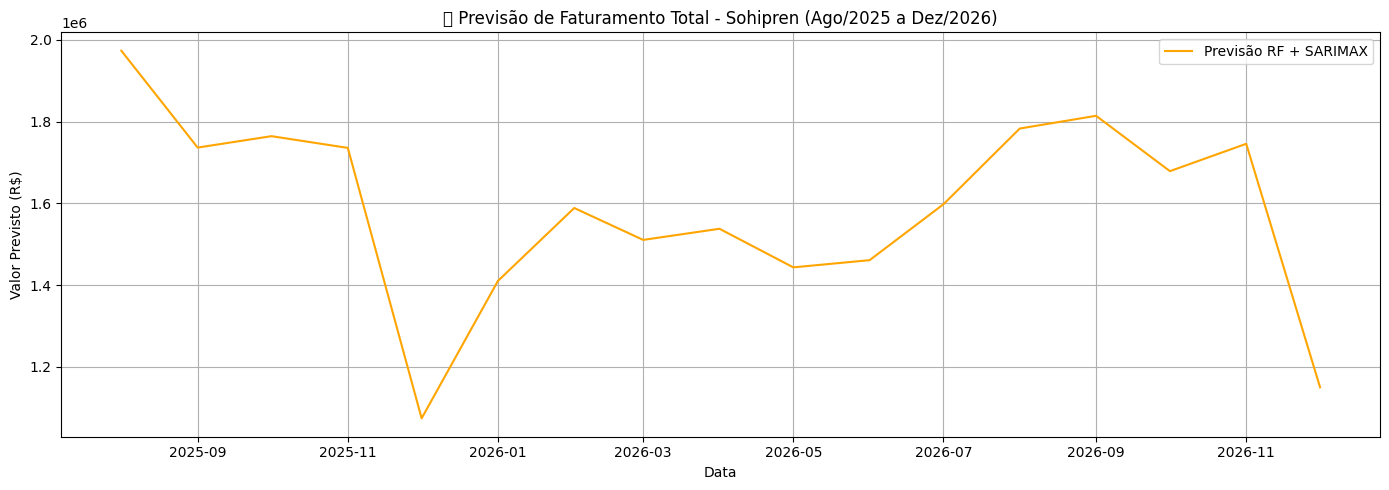

In [ ]:
#🔮 Previsão Geral de Vendas (Ago/2025 - Dez/2026) com RF + SARIMAX

# Agrupar vendas totais por mês
# Agrupa os dados por categorias para sumarização
df_total_mes = df.groupby(['ANO', 'MES'])['VALOR TOTAL'].sum().reset_index()
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
df_total_mes['MES_SENO'] = np.sin(2 * np.pi * df_total_mes['MES'] / 12)
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
df_total_mes['MES_COSSENO'] = np.cos(2 * np.pi * df_total_mes['MES'] / 12)

# Dataset futuro
futuras_datas = pd.date_range("2025-08-01", "2026-12-01", freq="MS")
df_futuro = pd.DataFrame({
    'ANO': futuras_datas.year,
    'MES': futuras_datas.month,
})
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
df_futuro['MES_SENO'] = np.sin(2 * np.pi * df_futuro['MES'] / 12)
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
df_futuro['MES_COSSENO'] = np.cos(2 * np.pi * df_futuro['MES'] / 12)

# Modelo RF
X = df_total_mes[['ANO', 'MES_SENO', 'MES_COSSENO']]
y = df_total_mes['VALOR TOTAL']

# Define e treina um modelo Random Forest para previsão
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
# Treina o modelo com os dados de entrada
modelo_rf.fit(X, y)
# Realiza a previsão com o modelo treinado
previsao_rf = modelo_rf.predict(df_futuro[['ANO', 'MES_SENO', 'MES_COSSENO']])

# Resíduos
# Realiza a previsão com o modelo treinado
residuos = y.values - modelo_rf.predict(X)

# Modelo SARIMAX nos resíduos
# Define e treina um modelo SARIMAX para modelar os resíduos
modelo_sarimax = SARIMAX(residuos, order=(1, 0, 0), seasonal_order=(1, 1, 1, 12))
# Treina o modelo com os dados de entrada
resultado_sarimax = modelo_sarimax.fit(disp=False)
# Realiza a previsão com o modelo SARIMAX para o futuro
previsao_sarimax = resultado_sarimax.forecast(len(df_futuro))

# Previsão final
previsao_final = previsao_rf + previsao_sarimax
df_futuro['PREVISAO FINAL'] = previsao_final
df_futuro['DATA'] = futuras_datas

# 📊 Gráfico da previsão
plt.figure(figsize=(14, 5))
# Gera um gráfico com os dados agrupados
plt.plot(df_futuro['DATA'], df_futuro['PREVISAO FINAL'], label='Previsão RF + SARIMAX', color='orange')
plt.title('📈 Previsão de Faturamento Total - Sohipren (Ago/2025 a Dez/2026)')
plt.xlabel('Data')
plt.ylabel('Valor Previsto (R$)')
plt.grid(True)
plt.legend()
plt.tight_layout()
# Exibe o gráfico gerado
plt.show()

## 5. Previsão de Vendas por Região

Utilizamos o mesmo modelo híbrido (Random Forest + SARIMAX) por região para apoiar a tomada de decisão geográfica.


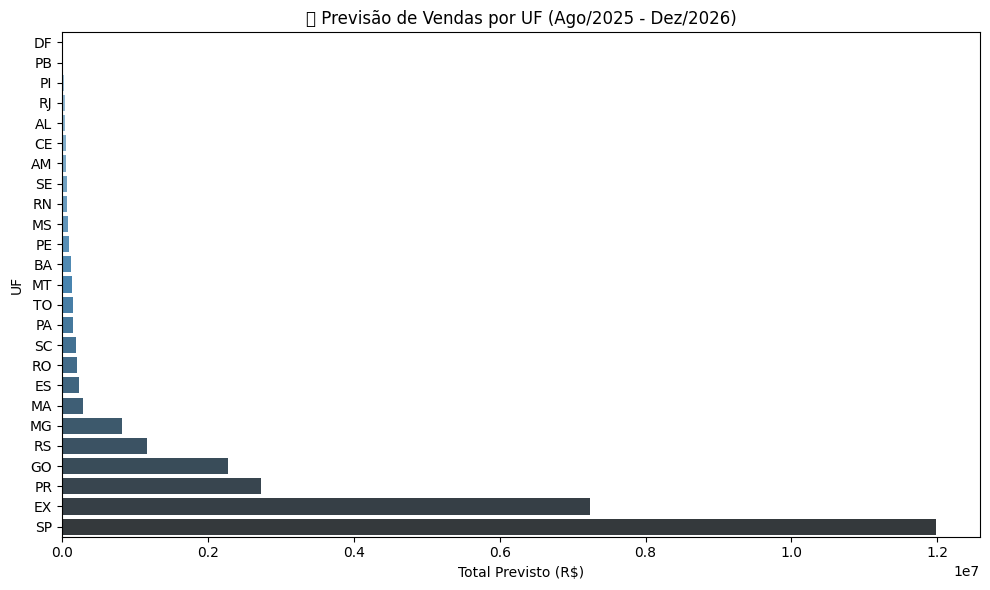

In [ ]:
# 🌍 Previsão de Vendas por UF (RF + SARIMAX)

# Agrupa os dados por categorias para sumarização
df_reg_mes = df.groupby(['UF', 'ANO', 'MES'])['VALOR TOTAL'].sum().reset_index()
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
df_reg_mes['MES_SENO'] = np.sin(2 * np.pi * df_reg_mes['MES'] / 12)
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
df_reg_mes['MES_COSSENO'] = np.cos(2 * np.pi * df_reg_mes['MES'] / 12)

futuro_reg = []
# Remove valores ausentes antes de processar
for uf in df['UF'].dropna().unique():
    for data in futuras_datas:
# Armazena os resultados da previsão em uma lista para posterior análise
        futuro_reg.append({
            'UF': uf,
            'ANO': data.year,
            'MES': data.month,
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
            'MES_SENO': np.sin(2 * np.pi * data.month / 12),
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
            'MES_COSSENO': np.cos(2 * np.pi * data.month / 12)
        })

df_futuro_reg = pd.DataFrame(futuro_reg)
resultados_regionais = []

# Remove valores ausentes antes de processar
for uf in df['UF'].dropna().unique():
    df_r = df_reg_mes[df_reg_mes['UF'] == uf]
    if len(df_r) < 6:
        continue
    X = df_r[['ANO', 'MES_SENO', 'MES_COSSENO']]
    y = df_r['VALOR TOTAL']

# Define e treina um modelo Random Forest para previsão
    modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
# Treina o modelo com os dados de entrada
    modelo_rf.fit(X, y)
# Realiza a previsão com o modelo treinado
    pred_rf = modelo_rf.predict(df_futuro_reg[df_futuro_reg['UF'] == uf][['ANO', 'MES_SENO', 'MES_COSSENO']])
# Realiza a previsão com o modelo treinado
    residuos = y.values - modelo_rf.predict(X)

    try:
# Define e treina um modelo SARIMAX para modelar os resíduos
        sarimax = SARIMAX(residuos, order=(1,0,0), seasonal_order=(1,1,1,12))
        sarimax_fit = sarimax.fit(disp=False)
# Realiza a previsão com o modelo SARIMAX para o futuro
        pred_sarimax = sarimax_fit.forecast(len(pred_rf))
    except:
        pred_sarimax = np.zeros(len(pred_rf))

    previsao_final = pred_rf + pred_sarimax
# Armazena os resultados da previsão em uma lista para posterior análise
    resultados_regionais.append({
        'UF': uf,
        'TOTAL PREVISTO': sum(previsao_final)
    })

# 📊 Gráfico
df_resultados_reg = pd.DataFrame(resultados_regionais).sort_values(by='TOTAL PREVISTO')
plt.figure(figsize=(10, 6))
# Gera um gráfico com os dados agrupados
sns.barplot(data=df_resultados_reg, x='TOTAL PREVISTO', y='UF', palette='Blues_d')
plt.title('📍 Previsão de Vendas por UF (Ago/2025 - Dez/2026)')
plt.xlabel('Total Previsto (R$)')
plt.ylabel('UF')
plt.tight_layout()
# Exibe o gráfico gerado
plt.show()

## 6. Previsão de Produtos Mais Vendidos

Aqui focamos em prever as vendas dos principais produtos da empresa, buscando quais devem ser priorizados em estoque.


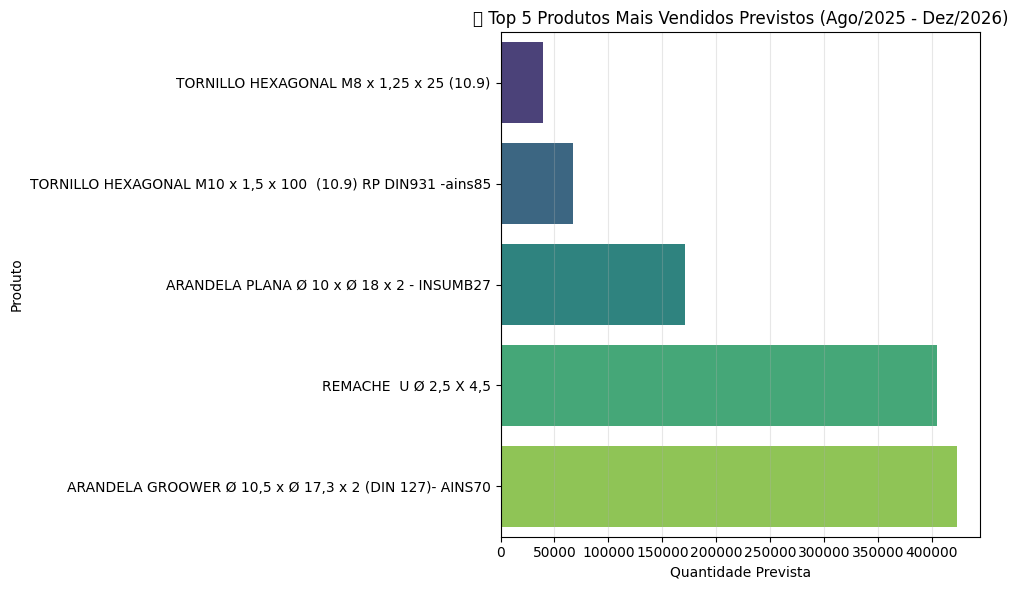

In [ ]:
# 🛒 Previsão dos Top 5 Produtos Mais Vendidos (RF + SARIMAX)

# 1. Agrupar e identificar os Top 5 produtos com maior volume histórico
top5_produtos = (
# Agrupa os dados por categorias para sumarização
    df.groupby('DESCRIÇÃO MATERIAL')['QUANTIDADE']
    .sum().sort_values(ascending=False)
    .head(5).index
)

# 2. Preparar dados mensais por produto
# Agrupa os dados por categorias para sumarização
df_prod_mes = df.groupby(['DESCRIÇÃO MATERIAL', 'ANO', 'MES'])['QUANTIDADE'].sum().reset_index()
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
df_prod_mes['MES_SENO'] = np.sin(2 * np.pi * df_prod_mes['MES'] / 12)
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
df_prod_mes['MES_COSSENO'] = np.cos(2 * np.pi * df_prod_mes['MES'] / 12)

# 3. Criar base futura (ago/2025 a dez/2026)
futuro_prod = []
for prod in top5_produtos:
    for data in futuras_datas:
# Armazena os resultados da previsão em uma lista para posterior análise
        futuro_prod.append({
            'DESCRIÇÃO MATERIAL': prod,
            'ANO': data.year,
            'MES': data.month,
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
            'MES_SENO': np.sin(2 * np.pi * data.month / 12),
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
            'MES_COSSENO': np.cos(2 * np.pi * data.month / 12)
        })

df_futuro_prod = pd.DataFrame(futuro_prod)

# 4. Treinar modelos e prever
resultados_prod = []

for prod in top5_produtos:
    df_p = df_prod_mes[df_prod_mes['DESCRIÇÃO MATERIAL'] == prod]
    if len(df_p) < 6:
        continue

    X = df_p[['ANO', 'MES_SENO', 'MES_COSSENO']]
    y = df_p['QUANTIDADE']

# Define e treina um modelo Random Forest para previsão
    rf = RandomForestRegressor(n_estimators=50, random_state=42)
    rf.fit(X, y)

    X_futuro = df_futuro_prod[df_futuro_prod['DESCRIÇÃO MATERIAL'] == prod][['ANO', 'MES_SENO', 'MES_COSSENO']]
# Realiza a previsão com o modelo treinado
    pred_rf = rf.predict(X_futuro)

    # SARIMAX nos resíduos
# Realiza a previsão com o modelo treinado
    residuos = y.values - rf.predict(X)
    try:
# Define e treina um modelo SARIMAX para modelar os resíduos
        sarimax = SARIMAX(residuos, order=(1,0,0), seasonal_order=(1,1,1,12))
        sarimax_fit = sarimax.fit(disp=False)
# Realiza a previsão com o modelo SARIMAX para o futuro
        pred_sarimax = sarimax_fit.forecast(len(pred_rf))
    except:
        pred_sarimax = np.zeros(len(pred_rf))

    previsao_final = pred_rf + pred_sarimax
# Armazena os resultados da previsão em uma lista para posterior análise
    resultados_prod.append({
        'Produto': prod,
        'TOTAL PREVISTO': sum(previsao_final)
    })

# 5. Plotar resultado
df_result_prod = pd.DataFrame(resultados_prod).sort_values(by='TOTAL PREVISTO')
plt.figure(figsize=(10, 6))
# Gera um gráfico com os dados agrupados
sns.barplot(data=df_result_prod, x='TOTAL PREVISTO', y='Produto', palette='viridis')
plt.title('⭐ Top 5 Produtos Mais Vendidos Previstos (Ago/2025 - Dez/2026)')
plt.xlabel('Quantidade Prevista')
plt.ylabel('Produto')
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
# Exibe o gráfico gerado
plt.show()

## 7. Previsão de Produtos Mais Vendidos por Região

Combinamos os dois aspectos: produto + regionalização, visando apoiar operações locais.


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


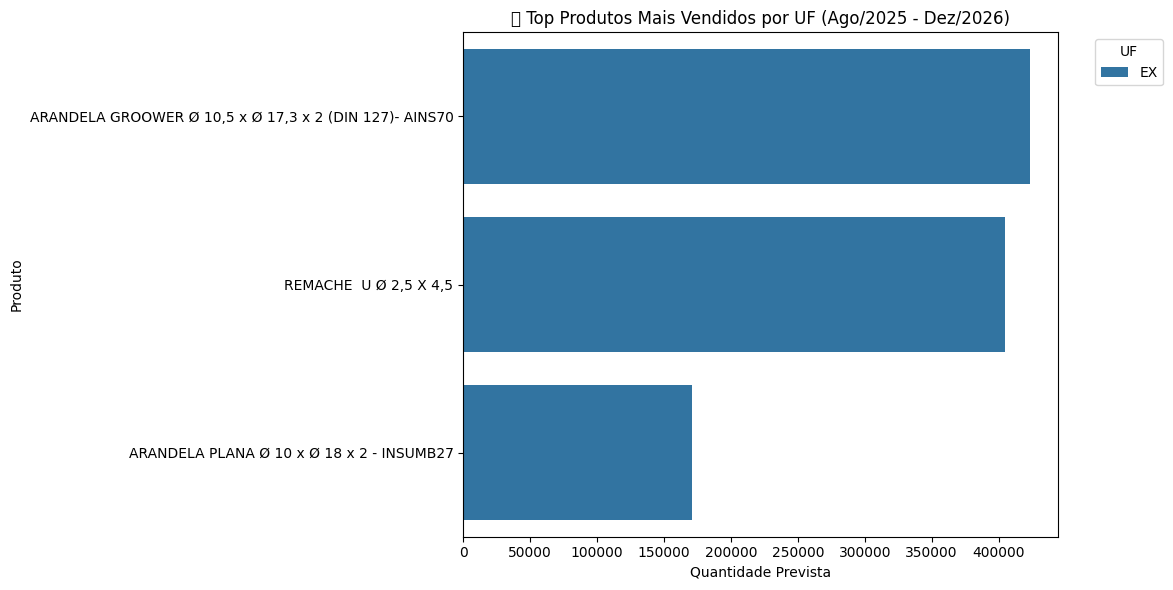

In [ ]:
# 🧩 Previsão dos Top 5 Produtos Mais Vendidos por Região (RF + SARIMAX)

# 1. Identificar os Top 5 produtos no total histórico
top5_produtos = (
# Agrupa os dados por categorias para sumarização
    df.groupby('DESCRIÇÃO MATERIAL')['QUANTIDADE']
    .sum().sort_values(ascending=False).head(5).index
)

# 2. Filtrar apenas os dados dos top 5 produtos
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
df_filtrado_top5 = df[df['DESCRIÇÃO MATERIAL'].isin(top5_produtos)]

# 3. Agrupar os dados mensais por produto e UF
# Agrupa os dados por categorias para sumarização
df_prod_reg = df_filtrado_top5.groupby(['UF', 'DESCRIÇÃO MATERIAL', 'ANO', 'MES'])['QUANTIDADE'].sum().reset_index()
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
df_prod_reg['MES_SENO'] = np.sin(2 * np.pi * df_prod_reg['MES'] / 12)
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
df_prod_reg['MES_COSSENO'] = np.cos(2 * np.pi * df_prod_reg['MES'] / 12)

# 4. Base futura
futuro_prod_reg = []
# Remove valores ausentes antes de processar
for uf in df_filtrado_top5['UF'].dropna().unique():
    for prod in top5_produtos:
        for data in futuras_datas:
# Armazena os resultados da previsão em uma lista para posterior análise
            futuro_prod_reg.append({
                'UF': uf,
                'DESCRIÇÃO MATERIAL': prod,
                'ANO': data.year,
                'MES': data.month,
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
                'MES_SENO': np.sin(2 * np.pi * data.month / 12),
# Cria variáveis sazonais baseadas nos meses usando seno e cosseno
                'MES_COSSENO': np.cos(2 * np.pi * data.month / 12)
            })

df_futuro_prod_reg = pd.DataFrame(futuro_prod_reg)
resultados_prod_reg = []

# 5. Loop pelas combinações UF + Produto
# Remove valores ausentes antes de processar
agrupamento = df_filtrado_top5[['UF', 'DESCRIÇÃO MATERIAL']].dropna().drop_duplicates()

for idx, linha in tqdm(agrupamento.iterrows(), total=agrupamento.shape[0]):
    uf = linha['UF']
    prod = linha['DESCRIÇÃO MATERIAL']
    df_sub = df_prod_reg[(df_prod_reg['UF'] == uf) & (df_prod_reg['DESCRIÇÃO MATERIAL'] == prod)]

    if len(df_sub) < 6:
        continue

    X = df_sub[['ANO', 'MES_SENO', 'MES_COSSENO']]
    y = df_sub['QUANTIDADE']

# Define e treina um modelo Random Forest para previsão
    rf = RandomForestRegressor(n_estimators=50, random_state=42)
    rf.fit(X, y)

    X_fut = df_futuro_prod_reg[(df_futuro_prod_reg['UF'] == uf) & (df_futuro_prod_reg['DESCRIÇÃO MATERIAL'] == prod)][['ANO', 'MES_SENO', 'MES_COSSENO']]
# Realiza a previsão com o modelo treinado
    pred_rf = rf.predict(X_fut)

# Realiza a previsão com o modelo treinado
    residuos = y.values - rf.predict(X)

    try:
# Define e treina um modelo SARIMAX para modelar os resíduos
        sarimax = SARIMAX(residuos, order=(1,0,0), seasonal_order=(1,1,1,12))
        sarimax_fit = sarimax.fit(disp=False)
# Realiza a previsão com o modelo SARIMAX para o futuro
        pred_sarimax = sarimax_fit.forecast(len(pred_rf))
    except:
        pred_sarimax = np.zeros(len(pred_rf))

    previsao_final = pred_rf + pred_sarimax
# Armazena os resultados da previsão em uma lista para posterior análise
    resultados_prod_reg.append({
        'UF': uf,
        'PRODUTO': prod,
        'TOTAL PREVISTO': sum(previsao_final)
    })

# 6. Resultado e visualização
df_result_prod_reg = pd.DataFrame(resultados_prod_reg)
# Agrupa os dados por categorias para sumarização
top_por_uf = df_result_prod_reg.sort_values(['UF', 'TOTAL PREVISTO'], ascending=[True, False]).groupby('UF').head(3)

plt.figure(figsize=(12, 6))
# Gera um gráfico com os dados agrupados
sns.barplot(data=top_por_uf, x='TOTAL PREVISTO', y='PRODUTO', hue='UF')
plt.title('🏆 Top Produtos Mais Vendidos por UF (Ago/2025 - Dez/2026)')
plt.xlabel('Quantidade Prevista')
plt.ylabel('Produto')
plt.legend(title='UF', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# Exibe o gráfico gerado
plt.show()


## ✅ 8. Conclusão e Insights Finais

### 📊 Visão Geral

Este projeto teve como objetivo prever as vendas da empresa **Sohipren** entre **Agosto de 2025 e Dezembro de 2026**, utilizando modelos híbridos de Machine Learning (Random Forest + SARIMAX) aplicados a diferentes níveis de granularidade: total, por região e por produto.

---

### 🔍 Principais Descobertas

#### 1️⃣ **Faturamento Total**
- Picos claros de vendas em determinados meses indicam **sazonalidade**.
- Possibilidade de preparar estoques e equipes para os meses de maior demanda.

#### 2️⃣ **Vendas por Região (UF)**
- **SP** concentra a maior parte das vendas (mais de R$ 12 milhões).
- Estados como **PR** e **GO** também são relevantes.
- Muitos estados apresentam vendas muito baixas, indicando oportunidades inexploradas ou focos bem definidos.

#### 3️⃣ **Top Produtos**
- Peças como **ARANDELA GROOWER**, **REMACHE U**, e **ARANDELA PLANA** são os itens com maior volume previsto.
- Estas peças devem ser tratadas com prioridade em abastecimento e produção.

#### 4️⃣ **Produtos por Região**
- A distribuição dos produtos varia pouco entre as regiões de maior volume.
- A categoria "EX" (provavelmente exportações) representa uma oportunidade importante de crescimento.

---

### 💡 Conclusão Estratégica

A ferramenta desenvolvida permite à Sohipren:
- 📦 **Planejar estoque com base em dados reais e previsão inteligente**;
- 🚚 **Focar esforços logísticos nas regiões com maior retorno**;
- 🛠️ **Priorizar a fabricação de itens com maior saída**;
- 🌍 **Explorar mercados ainda não atendidos ou com registros incompletos**;
- 📈 **Aumentar a competitividade por meio de automação e previsibilidade**.

---

✨ **Este projeto é um primeiro passo para transformar a gestão de vendas da Sohipren em um processo orientado por dados e inteligência artificial.**
""")


